# Anime Recommender Functions

In [1]:
import numpy as np
import pandas as pd
import sklearn

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
dataset = pd.read_csv('anime.csv')
dataset.head()
dataset = dataset[0:15000]

In [4]:
genre = dataset['genre']
title = dataset['title']

for i, t in enumerate(title):
    title[i] = t.lower()

In [5]:
title.head()

0             haikyuu!! second season
1             shigatsu wa kimi no uso
2                       made in abyss
3    fullmetal alchemist: brotherhood
4    kizumonogatari iii: reiketsu-hen
Name: title, dtype: object

In [6]:
'''
for i, ind_genre in enumerate(genre):
    ind_genre = ind_genre.replace('[', '')
    ind_genre = ind_genre.replace(']', '')
    ind_genre = ind_genre.replace("'", "")
    ind_genre = ind_genre.replace(',', '')
    genre.iloc[i] = ind_genre
'''

'\nfor i, ind_genre in enumerate(genre):\n    ind_genre = ind_genre.replace(\'[\', \'\')\n    ind_genre = ind_genre.replace(\']\', \'\')\n    ind_genre = ind_genre.replace("\'", "")\n    ind_genre = ind_genre.replace(\',\', \'\')\n    genre.iloc[i] = ind_genre\n'

In [7]:
genre

0        ['Comedy', 'Sports', 'Drama', 'School', 'Shoun...
1        ['Drama', 'Music', 'Romance', 'School', 'Shoun...
2        ['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...
3        ['Action', 'Military', 'Adventure', 'Comedy', ...
4         ['Action', 'Mystery', 'Supernatural', 'Vampire']
                               ...                        
14995            ['Action', 'Kids', 'Adventure', 'Comedy']
14996             ['Action', 'Magic', 'Fantasy', 'Shoujo']
14997                         ['Slice of Life', 'Fantasy']
14998                                ['Sci-Fi', 'Mystery']
14999           ['Action', 'Adventure', 'Mecha', 'Sci-Fi']
Name: genre, Length: 15000, dtype: object

In [8]:
m = dataset['score'].quantile(0.8)
print(m)
top_anime = dataset.copy().loc[dataset['score'] >= m]
top_anime = top_anime.drop_duplicates(subset='title')
top_anime.shape

7.4


(2184, 12)

In [9]:
top_anime = top_anime.sort_values('score', ascending=False)
top_anime[['title', 'members', 'ranked', 'score']].head(10)

,title,members,ranked,score
3,fullmetal alchemist: brotherhood,1615084,1.0,9.23
773,steins;gate,1331710,2.0,9.11
772,hunter x hunter (2011),1052761,3.0,9.11
771,kimi no na wa.,1139878,4.0,9.09
12771,quiz de manabu pinocchio no koutsuu ansen,90,13630.0,9.08
770,shingeki no kyojin season 3 part 2,446370,5.0,9.07
769,gintama°,281594,6.0,9.05
768,gintama',278110,7.0,9.04
767,ginga eiyuu densetsu,175423,8.0,9.03
766,3-gatsu no lion 2nd season,169544,9.0,9.02


Text(0.5, 1.0, 'Member Size')

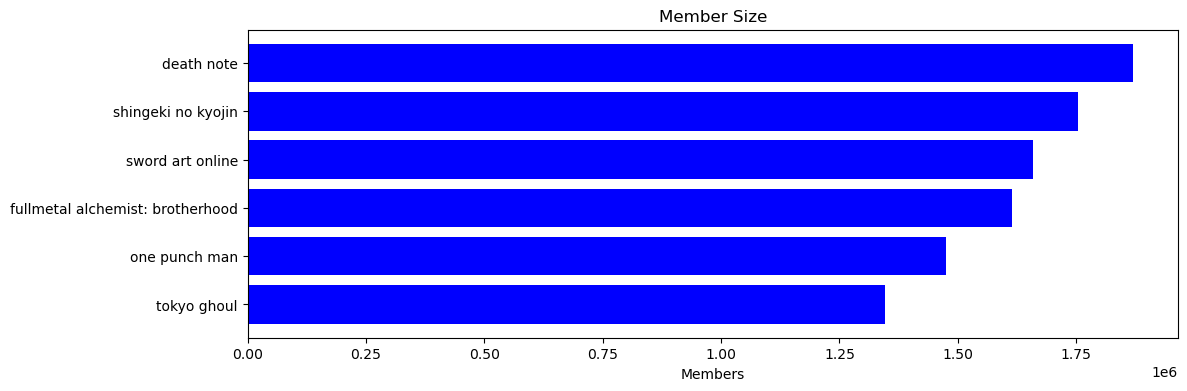

In [10]:
import matplotlib.pyplot as plt

membersize = top_anime.sort_values('members', ascending=False)
plt.figure(figsize=(12, 4))
plt.barh(membersize['title'].head(6), membersize['members'].head(6), align='center', color='blue')
plt.gca().invert_yaxis()
plt.xlabel("Members")
plt.title("Member Size")

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tfidf = TfidfVectorizer(stop_words='english')
top_anime['synopsis'] = top_anime['synopsis'].fillna('')
tfidf_matrix = tfidf.fit_transform(top_anime['synopsis'])
tfidf_matrix.shape

(2184, 18774)

In [13]:
from sklearn.metrics.pairwise import linear_kernel

In [14]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(top_anime.index, index=top_anime['title']).drop_duplicates()

In [15]:
top_anime = top_anime.sort_values('score', ascending=False)

def get_recs(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    anime_indices = [i[0] for i in sim_scores]
    
    return top_anime['title'].iloc[anime_indices]

In [16]:
get_recs('Shigatsu wa Kimi no Uso'.casefold())

709                            steins;gate 0
706                            mo dao zu shi
642                               grand blue
556                 little busters!: refrain
10338    bokutachi wa benkyou ga dekinai ova
                        ...                 
14831                           afro samurai
14988                  aa! megami-sama! (tv)
13111                 shippai ippai mo ikkai
14992                aa! megami-sama! (2011)
14825               aishen qiaokeli-ing...ii
Name: title, Length: 2183, dtype: object

In [17]:
from ast import literal_eval

In [18]:
features = ['genre']
for feature in features:
    top_anime[feature] = top_anime[feature].apply(literal_eval)

In [19]:
def create_soup(x):
    return ' '.join(x['genre'])
top_anime['soup'] = top_anime.apply(create_soup, axis=1)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(top_anime['soup'])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
cos_sim_genre = cosine_similarity(count_matrix, count_matrix)

In [24]:
top_anime = top_anime.reset_index()
indices = pd.Series(top_anime.index, index=top_anime['title'])

In [25]:
recs = get_recs('shokugeki no souma'.casefold(), cos_sim_genre)

In [26]:
recs

172                        shokugeki no souma: ni no sara
190                       shokugeki no souma: san no sara
245     shokugeki no souma: san no sara - tootsuki res...
792                      shokugeki no souma: shin no sara
1324                   shokugeki no souma: ni no sara ova
                              ...                        
2177                        shitamachi alien papipipipupi
2178    oyako de manabu: kaiji no youjin - jishin no y...
2179                                   tobidashicha dame!
2180                          xing you ji: fengbao famila
2182                     nibiki no neko to genkina kazoku
Name: title, Length: 2183, dtype: object

# Flask App

In [27]:
import flask
from flask import Flask, request, render_template, jsonify

In [28]:
app = Flask(__name__)

In [29]:
@app.route('/')
def index():
    return flask.render_template('index.html')

In [30]:
suggestions = top_anime['title'].tolist()
for i, t in enumerate(suggestions):
    suggestions[i] = {'value':t, 'data':t}
    
suggestions

[{'value': 'fullmetal alchemist: brotherhood',
  'data': 'fullmetal alchemist: brotherhood'},
 {'value': 'hunter x hunter (2011)', 'data': 'hunter x hunter (2011)'},
 {'value': 'steins;gate', 'data': 'steins;gate'},
 {'value': 'kimi no na wa.', 'data': 'kimi no na wa.'},
 {'value': 'quiz de manabu pinocchio no koutsuu ansen',
  'data': 'quiz de manabu pinocchio no koutsuu ansen'},
 {'value': 'shingeki no kyojin season 3 part 2',
  'data': 'shingeki no kyojin season 3 part 2'},
 {'value': 'gintama°', 'data': 'gintama°'},
 {'value': "gintama'", 'data': "gintama'"},
 {'value': 'ginga eiyuu densetsu', 'data': 'ginga eiyuu densetsu'},
 {'value': '3-gatsu no lion 2nd season', 'data': '3-gatsu no lion 2nd season'},
 {'value': 'koe no katachi', 'data': 'koe no katachi'},
 {'value': "gintama': enchousen", 'data': "gintama': enchousen"},
 {'value': 'clannad: after story', 'data': 'clannad: after story'},
 {'value': 'gintama', 'data': 'gintama'},
 {'value': 'gintama movie 2: kanketsu-hen - yorozu

In [31]:
@app.route('/search/<string:box>')
def process(box):
    query = request.args.get('query')
    if box == 'title':
        global suggestions
    return jsonify({"suggestions":suggestions})

In [32]:
ind = 0
predicted_list = np.array(top_anime)

@app.route('/predict', methods=['POST'])
def get_prediction():
    if request.method == 'POST':
        anime_title = request.form.get("title")
        pred = get_recs(str(anime_title).casefold(), cos_sim_genre)
        prediction = np.array(pred)
        global predicted_list
        predicted_list = prediction
    global ind
    return render_template("predict.html", prediction = prediction[ind])

In [33]:
@app.route('/prev', methods=['POST'])
def prev_prediction():
    if request.method == 'POST':
        global ind
        if ind > 0:
            ind -= 1
    global predicted_list
    return render_template("predict.html", prediction = predicted_list[ind])

@app.route('/next', methods=['POST'])
def next_prediction():
    if request.method == 'POST':
        global ind
        ind += 1
    global predicted_list
    return render_template("predict.html", prediction = predicted_list[ind])

In [34]:
@app.route('/back', methods=['POST'])
def back():
    if request.method == 'POST':
        global ind
        ind = 0
    return flask.render_template('index.html')

In [35]:
if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Jan/2023 04:54:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:15] "GET /search/titles?query=o HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:16] "GET /search/titles?query=on HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:16] "GET /search/titles?query=one HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:16] "GET /search/titles?query=one%20 HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:16] "GET /search/titles?query=one%20p HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:17] "GET /search/titles?query=one%20pi HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:17] "GET /search/titles?query=one%20pie HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:17] "GET /search/titles?query=one%20piec HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:17] "GET /search/titles?query=one%20piece HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:21] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2023 04:54:23] "